In [ ]:
# This is a reimplementation of Residual Attention Network for Image Classification
# https://arxiv.org/abs/1704.06904
# Xin Huang (UNI: xh2510), Qimeng Tao (UNI: qt2139), Kangrui Li (UNI: kl3350)
# ECBM 4040 Deep Learning & Neural Networks 2021Fall

In [1]:
#Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import random

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 21 20:24:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Cifar10 Dataset

In [2]:
#Load Dataset
(train_image, train_label), (test_image, test_label) = cifar10.load_data()
(train_image_100, train_label_100), (test_image_100, test_label_100) = cifar100.load_data()

169017344/169001437 [==============================] - 6s 0us/step


In [3]:
#Convert label to one-hot binary
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_label_100 = to_categorical(train_label_100)
test_label_100 = to_categorical(test_label_100)

In [4]:
#Noise Level
def add_noise(image, noise_level=0.1):
    scale = 1 + noise_level
    noise = random.normal(loc=0.0, scale=scale)
    image += noise
    return image

In [5]:
#Data Augmentation
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=None)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)

## Architecture

#### The architecture of the proposed network for ImageNet

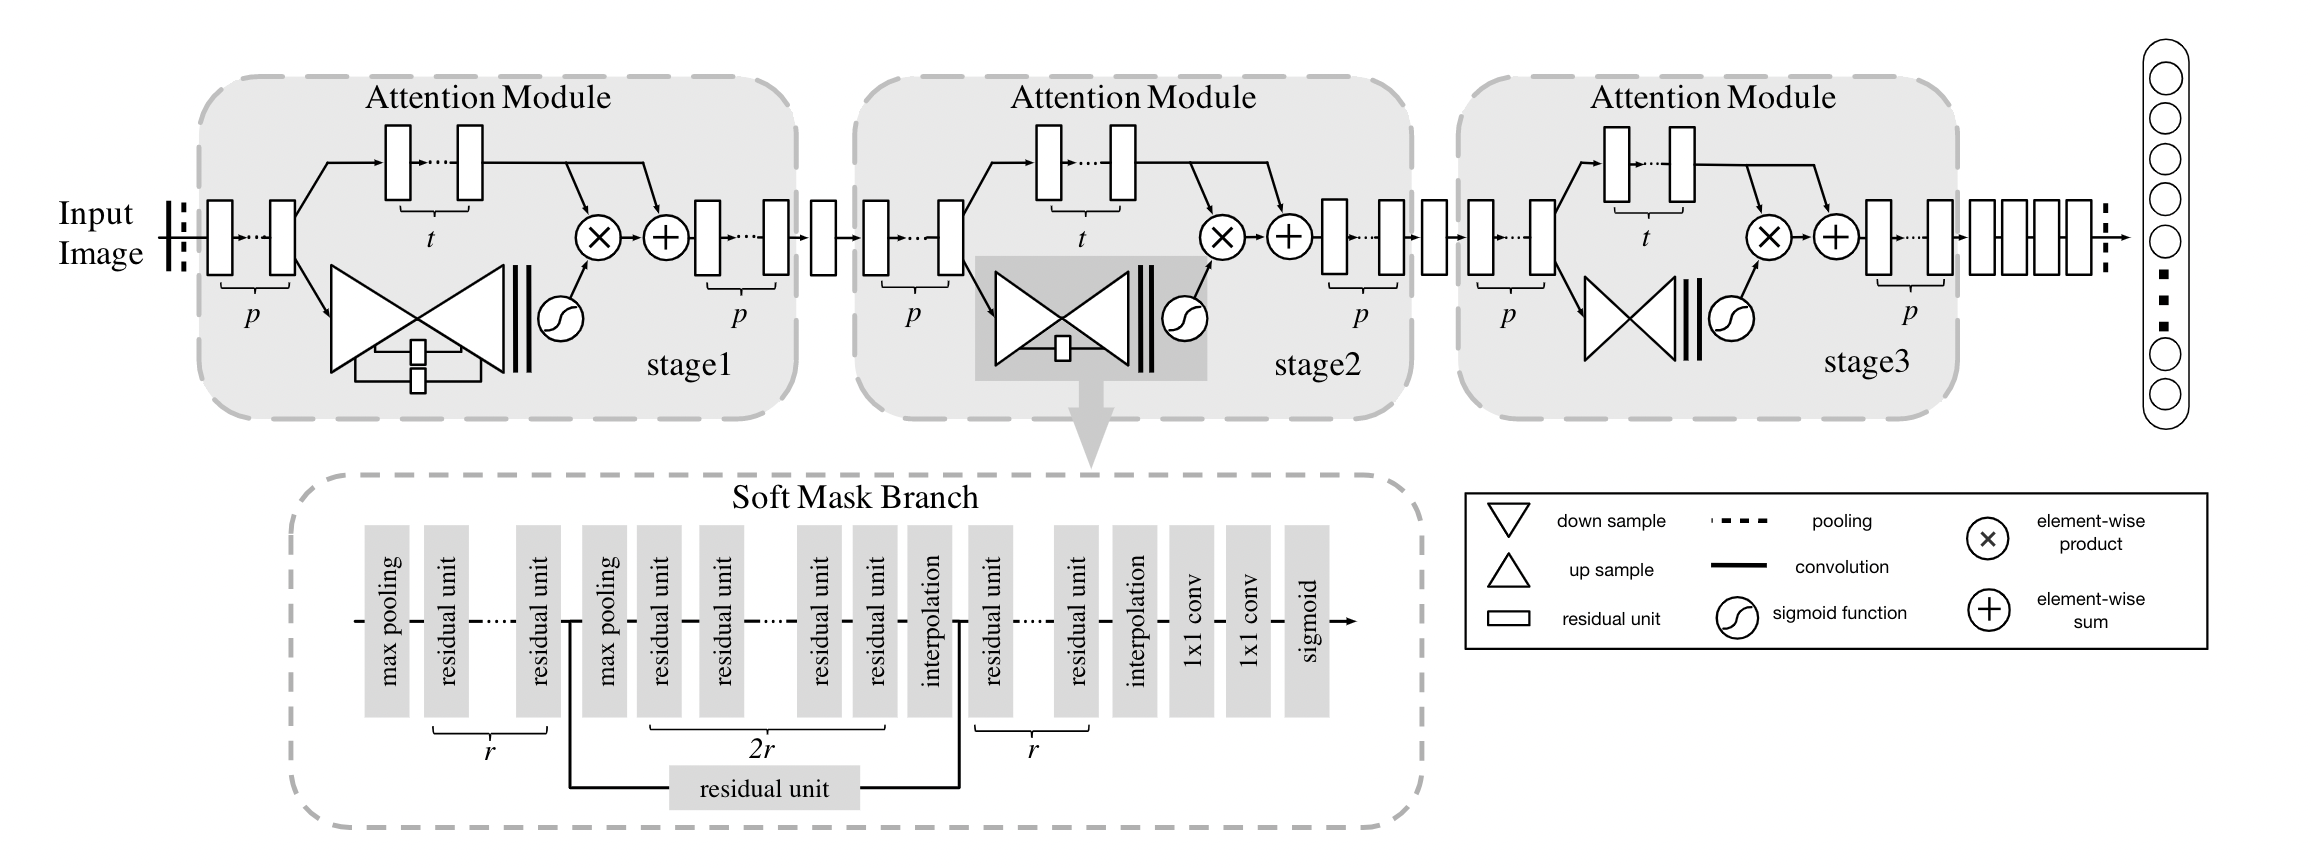

#### Residual Attention Network architecture details for ImageNet (Attention-56 and Attention-92, input shape(None, 224, 224, 3))

![image.png]()

Because the size of ImageNet is too large for this project to implement, we will use Cifar10 only instead of using ImageNet and Cifar100, therefore, the input shape is no longer (None, 224, 224, 3), instead, it will be (None, 32, 32, 3).

I have made some modifications to the original architecture since the model details for Cifar10 are not provided in the paper.

## Modules to build the model

### Residual unit

In [6]:
#Define Residual Unit
def residual_unit(X, filter_num_first, filter_num_final, stride = 1, short_cut=True):

    ShortCut = layers.Conv2D(filter_num_final, (1, 1), padding='same', strides=stride)(X)

    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filter_num_first, (1,1), padding='same')(X)

    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filter_num_first, (3,3), padding='same', strides = stride)(X)
    
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filter_num_final, (1,1), padding='same')(X)
    
    if short_cut == True:
        X = layers.Add()([X, ShortCut])
    
    return X

### Attention Module

In [7]:
#Attention module with encoder depth 
# r: num of residual units in Down/Up sampling
# p: num of residual units before and after Soft Mask Branch and Trunk Branch
# t: num of residual units in the Trunk Branch

def attention_module(X, filter_num_first, filter_num_final, depth=1):
    
    #Input
    X = residual_unit(X, filter_num_first, filter_num_final, short_cut=True) # p = 1
    
    #Trunk Branch: t = 2
    Trunk = residual_unit(X, filter_num_first, filter_num_final, short_cut=True)
    Trunk = residual_unit(Trunk, filter_num_first, filter_num_final, short_cut=True)

    #Soft Mask Branch
    ##Down Sampling: r = 1
    Mask = layers.MaxPool2D(pool_size=(2, 2), padding='same')(X)
    Mask = residual_unit(Mask, filter_num_first, filter_num_final, short_cut=True)
    
    skip_connection = []
    for i in range(depth - 1):
      
      skip_connection_list = residual_unit(Mask, filter_num_first, filter_num_final, short_cut=True)
      skip_connection.append(skip_connection_list)
      
      Mask = layers.MaxPool2D(pool_size=(2, 2), padding='same')(Mask)
      Mask = residual_unit(Mask, filter_num_first, filter_num_final, short_cut=True) # r = 1
    
    skip_connection_reverse = list(reversed(skip_connection))

    ##Up Sampling: r = 1
    for i in range(depth - 1): 
      
      Mask = residual_unit(Mask, filter_num_first, filter_num_final, short_cut=True) # r = 1
      Mask = layers.UpSampling2D()(Mask) 

      Mask = layers.Add()([Mask, skip_connection_reverse[i]])

    Mask = residual_unit(Mask, filter_num_first, filter_num_final, short_cut=True)
    Mask = layers.UpSampling2D()(Mask)   
    
    Mask = layers.BatchNormalization()(Mask)
    Mask = layers.Activation('relu')(Mask)
    Mask = layers.Conv2D(filter_num_final, (1,1), padding='same')(Mask)
    Mask = layers.BatchNormalization()(Mask)
    Mask = layers.Activation('relu')(Mask)
    Mask = layers.Conv2D(filter_num_final, (1,1), padding='same')(Mask)
    Mask = layers.Activation('sigmoid')(Mask)
    
    #Implement: H = (1 + M) * F
    Mask = layers.Lambda(lambda x: x + 1)(Mask)
    Out = layers.Multiply()([Mask, Trunk]) 
     
    Out = residual_unit(Out, filter_num_first, filter_num_final, short_cut=True) # p = 1

    return Out

### Other essential modules

In [8]:
learning_rate_reducer = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=10, min_lr=10e-8, min_delta=0.01, verbose=1)
early_stopper = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1)

## Models

### Attention 56 Model for Cifar10

#### Build Model

In [9]:
#Build the model (Attention-56)

#Model Input
ModelInput = layers.Input(shape=(32, 32, 3))

# Conv1
X = layers.Conv2D(32, (5, 5), padding='same')(ModelInput)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

#Max pooling
X = layers.MaxPool2D(pool_size=(2, 2))(X)

#Residual Unit 1
X = residual_unit(X, filter_num_first=32, filter_num_final=128, stride=1)

#Attention Module 1
X = attention_module(X, filter_num_first=128, filter_num_final=128, depth=2)

#Residual Unit 2
X = residual_unit(X, filter_num_first=128, filter_num_final=256, stride=2)

#Attention Module 2
X = attention_module(X, filter_num_first=256, filter_num_final=256, depth=1)

#Residual Unit 3
X = residual_unit(X, filter_num_first=256, filter_num_final=512, stride=2)

#Attention Module 3
X = attention_module(X, filter_num_first=512, filter_num_final=512)

#Residual Unit 4
X = residual_unit(X, filter_num_first=512, filter_num_final=1024)

X = residual_unit(X, filter_num_first=1024, filter_num_final=1024, short_cut=False)
X = residual_unit(X, filter_num_first=1024, filter_num_final=1024, short_cut=False)

X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.AveragePooling2D(pool_size=(4, 4), strides=(1, 1))(X)

#FC 
X = layers.Dropout(0.5)(X)
X = layers.Flatten()(X)
ModelOutput = layers.Dense(10, activation='softmax')(X)

model_attention_56_cifar10 = models.Model(ModelInput, ModelOutput)

In [ ]:
model_attention_56_cifar10.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_115 (Conv2D)            (None, 32, 32, 32)   2432        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_89 (BatchN  (None, 32, 32, 32)  128         ['conv2d_115[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_92 (Activation)     (None, 32, 32, 32)   0           ['batch_normalization_89[0]

#### Compile Model

In [ ]:
model_attention_56_cifar10.compile(optimizers.Adam(learning_rate=0.0001), loss=losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy']) 

In [ ]:
batch_size = 64
epochs = 100

history=model_attention_56_cifar10.fit_generator(train_datagen.flow(train_image, train_label, batch_size=batch_size),
                    steps_per_epoch=len(train_image)//batch_size, epochs = epochs,
                    validation_data=val_datagen.flow(test_image, test_label, batch_size=batch_size), 
                    validation_steps=len(test_image)//batch_size,
                    callbacks=[learning_rate_reducer, early_stopper])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


781/781 [==============================] - 127s 151ms/step - loss: 1.7443 - accuracy: 0.3700 - val_loss: 1.9497 - val_accuracy: 0.4130 - lr: 1.0000e-04
Epoch 2/100
781/781 [==============================] - 121s 155ms/step - loss: 1.4093 - accuracy: 0.4913 - val_loss: 1.8650 - val_accuracy: 0.4386 - lr: 1.0000e-04
Epoch 3/100
781/781 [==============================] - 109s 140ms/step - loss: 1.2367 - accuracy: 0.5593 - val_loss: 1.2612 - val_accuracy: 0.5807 - lr: 1.0000e-04
Epoch 4/100
781/781 [==============================] - 110s 140ms/step - loss: 1.1203 - accuracy: 0.6012 - val_loss: 1.1451 - val_accuracy: 0.6077 - lr: 1.0000e-04
Epoch 5/100
781/781 [==============================] - 109s 140ms/step - loss: 1.0319 - accuracy: 0.6362 - val_loss: 1.4206 - val_accuracy: 0.5894 - lr: 1.0000e-04
Epoch 6/100
781/781 [==============================] - 114s 146ms/step - loss: 0.9450 - accuracy: 0.6676 - val_loss: 1.2709 - val_accuracy: 0.5783 - lr: 1.0000e-04
Epoch 7/100
781/781 [=======

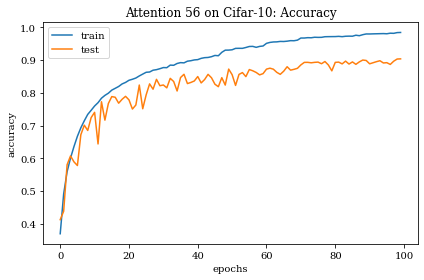

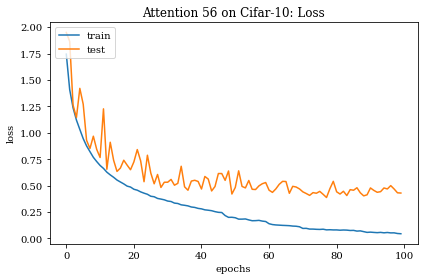

In [ ]:
import matplotlib.pyplot as plt

#Change font
plt.rc('font', family='serif')

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Attention 56 on Cifar-10: Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Attention 56 on Cifar-10: Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

### Attention 56 Model for Cifar 100

#### Build Model

In [10]:
#Build the model (Attention-56)

#Model Input
ModelInput = layers.Input(shape=(32, 32, 3))

# Conv1
X = layers.Conv2D(32, (5, 5), padding='same')(ModelInput)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

#Max pooling
X = layers.MaxPool2D(pool_size=(2, 2))(X)

#Residual Unit 1
X = residual_unit(X, filter_num_first=32, filter_num_final=128, stride=1)

#Attention Module 1
X = attention_module(X, filter_num_first=128, filter_num_final=128, depth=2)

#Residual Unit 2
X = residual_unit(X, filter_num_first=128, filter_num_final=256, stride=2)

#Attention Module 2
X = attention_module(X, filter_num_first=256, filter_num_final=256, depth=1)

#Residual Unit 3
X = residual_unit(X, filter_num_first=256, filter_num_final=512, stride=2)

#Attention Module 3
X = attention_module(X, filter_num_first=512, filter_num_final=512)

#Residual Unit 4
X = residual_unit(X, filter_num_first=512, filter_num_final=1024)

X = residual_unit(X, filter_num_first=1024, filter_num_final=1024, short_cut=False)
X = residual_unit(X, filter_num_first=1024, filter_num_final=1024, short_cut=False)

X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.AveragePooling2D(pool_size=(4, 4), strides=(1, 1))(X)

#FC 
#X = layers.Dropout(0.5)(X)
X = layers.Flatten()(X)
ModelOutput = layers.Dense(100, activation='softmax')(X)

model_attention_56_cifar100 = models.Model(ModelInput, ModelOutput)

#### Compile Model

In [11]:
model_attention_56_cifar100.compile(optimizers.Adam(learning_rate=0.0001), loss=losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy']) 

In [12]:
batch_size = 64
epochs = 100

model_attention_56_cifar100.fit(train_datagen.flow(train_image_100, train_label_100, batch_size=batch_size),
                    steps_per_epoch=len(train_image_100)//batch_size, epochs=epochs,
                    validation_data=val_datagen.flow(test_image_100, test_label_100, batch_size=batch_size), 
                    validation_steps=len(test_image_100)//batch_size,
                    callbacks=[learning_rate_reducer, early_stopper])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


781/781 [==============================] - 134s 148ms/step - loss: 3.7193 - accuracy: 0.1300 - val_loss: 3.5468 - val_accuracy: 0.1663 - lr: 1.0000e-04
Epoch 2/100
781/781 [==============================] - 113s 144ms/step - loss: 3.1495 - accuracy: 0.2241 - val_loss: 3.2860 - val_accuracy: 0.2188 - lr: 1.0000e-04
Epoch 3/100
781/781 [==============================] - 108s 138ms/step - loss: 2.8519 - accuracy: 0.2838 - val_loss: 2.7647 - val_accuracy: 0.3051 - lr: 1.0000e-04
Epoch 4/100
781/781 [==============================] - 114s 146ms/step - loss: 2.6145 - accuracy: 0.3292 - val_loss: 2.6450 - val_accuracy: 0.3291 - lr: 1.0000e-04
Epoch 5/100
781/781 [==============================] - 112s 143ms/step - loss: 2.4350 - accuracy: 0.3678 - val_loss: 2.9387 - val_accuracy: 0.2983 - lr: 1.0000e-04
Epoch 6/100
781/781 [==============================] - 107s 137ms/step - loss: 2.2630 - accuracy: 0.4063 - val_loss: 2.5941 - val_accuracy: 0.3511 - lr: 1.0000e-04
Epoch 7/100
781/781 [=======

### Attention 92 Model for Cifar 10

#### Build Model

In [13]:
#Build the model (Attention-56)

#Model Input
ModelInput = layers.Input(shape=(32, 32, 3))

# Conv1
X = layers.Conv2D(32, (5, 5), padding='same')(ModelInput)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

#Max pooling
X = layers.MaxPool2D(pool_size=(2, 2))(X)

#Residual Unit 1
X = residual_unit(X, filter_num_first=32, filter_num_final=128, stride=1)

#Attention Module 1
X = attention_module(X, filter_num_first=128, filter_num_final=128, depth=2)

#Residual Unit 2
X = residual_unit(X, filter_num_first=128, filter_num_final=256, stride=2)

#Attention Module 2
X = attention_module(X, filter_num_first=256, filter_num_final=256, depth=1)
X = attention_module(X, filter_num_first=256, filter_num_final=256, depth=1)

#Residual Unit 3
X = residual_unit(X, filter_num_first=256, filter_num_final=512, stride=2)

#Attention Module 3
X = attention_module(X, filter_num_first=512, filter_num_final=512)
X = attention_module(X, filter_num_first=512, filter_num_final=512)
X = attention_module(X, filter_num_first=512, filter_num_final=512)

#Residual Unit 4
X = residual_unit(X, filter_num_first=512, filter_num_final=1024)

X = residual_unit(X, filter_num_first=1024, filter_num_final=1024, short_cut=False)
X = residual_unit(X, filter_num_first=1024, filter_num_final=1024, short_cut=False)

X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.AveragePooling2D(pool_size=(4, 4), strides=(1, 1))(X)

#FC 
#X = layers.Dropout(0.5)(X)
X = layers.Flatten()(X)
ModelOutput = layers.Dense(10, activation='softmax')(X)

model_attention_92_cifar10 = models.Model(ModelInput, ModelOutput)

#### Compile Model

In [14]:
model_attention_92_cifar10.compile(optimizers.Adam(learning_rate=0.0001), loss=losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy']) 

In [18]:
batch_size = 64
epochs = 200

model_attention_92_cifar10.fit(train_datagen.flow(train_image, train_label, batch_size=batch_size),
                    steps_per_epoch=len(train_image)//batch_size, epochs=epochs,
                    validation_data=val_datagen.flow(test_image, test_label, batch_size=batch_size), 
                    validation_steps=len(test_image)//batch_size,
                    callbacks=[learning_rate_reducer, early_stopper])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
781/781 [==============================] - 173s 221ms/step - loss: 1.2076 - accuracy: 0.5670 - val_loss: 1.4973 - val_accuracy: 0.5176 - lr: 1.0000e-04
Epoch 2/50
781/781 [==============================] - 172s 220ms/step - loss: 1.1002 - accuracy: 0.6057 - val_loss: 1.5147 - val_accuracy: 0.5289 - lr: 1.0000e-04
Epoch 3/50
781/781 [==============================] - 172s 220ms/step - loss: 1.0186 - accuracy: 0.6383 - val_loss: 1.5098 - val_accuracy: 0.5442 - lr: 1.0000e-04
Epoch 4/50
781/781 [==============================] - 170s 218ms/step - loss: 0.9486 - accuracy: 0.6660 - val_loss: 0.9406 - val_accuracy: 0.6748 - lr: 1.0000e-04
Epoch 5/50
781/781 [==============================] - 172s 220ms/step - loss: 0.8934 - accuracy: 0.6855 - val_loss: 1.1921 - val_accuracy: 0.6048 - lr: 1.0000e-04
Epoch 6/50
781/781 [==============================] - 171s 219ms/step - loss: 0.8293 - accuracy: 0.7078 - val_loss: 0.8097 - val_accuracy: 0.7132 - lr: 1.0000e-04
Epoch 7/50
781/781 [==

### Attention 92 Model for Cifar 100

#### Build Model

In [ ]:
#Build the model (Attention-56)

#Model Input
ModelInput = layers.Input(shape=(32, 32, 3))

# Conv1
X = layers.Conv2D(32, (5, 5), padding='same')(ModelInput)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

#Max pooling
X = layers.MaxPool2D(pool_size=(2, 2))(X)

#Residual Unit 1
X = residual_unit(X, filter_num_first=32, filter_num_final=128, stride=1)

#Attention Module 1
X = attention_module(X, filter_num_first=128, filter_num_final=128, depth=2)

#Residual Unit 2
X = residual_unit(X, filter_num_first=128, filter_num_final=512, stride=2)

#Attention Module 2
X = attention_module(X, filter_num_first=512, filter_num_final=512, depth=1)
X = attention_module(X, filter_num_first=512, filter_num_final=512, depth=1)

#Residual Unit 3
X = residual_unit(X, filter_num_first=512, filter_num_final=1024, stride=2)

#Attention Module 3
X = attention_module(X, filter_num_first=1024, filter_num_final=1024)
X = attention_module(X, filter_num_first=1024, filter_num_final=1024)
X = attention_module(X, filter_num_first=1024, filter_num_final=1024)

#Residual Unit 4
X = residual_unit(X, filter_num_first=1024, filter_num_final=2048)

X = residual_unit(X, filter_num_first=2048, filter_num_final=2048, short_cut=False)
X = residual_unit(X, filter_num_first=2048, filter_num_final=2048, short_cut=False)

X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.AveragePooling2D(pool_size=(4, 4), strides=(1, 1))(X)

#FC 
#X = layers.Dropout(0.5)(X)
X = layers.Flatten()(X)
ModelOutput = layers.Dense(100, activation='softmax')(X)

model_attention_92_cifar100 = models.Model(ModelInput, ModelOutput)

In [ ]:
model_attention_92_cifar100.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

#### Compile Model

In [ ]:
model_attention_92_cifar100.compile(optimizers.Adam(learning_rate=0.0001), loss=losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy']) 

In [ ]:
batch_size = 64
epochs = 200

model_attention_92_cifar100.fit(train_datagen.flow(train_image_100, train_label_100, batch_size=batch_size),
                    steps_per_epoch=len(train_image_100)//batch_size, epochs=epochs,
                    validation_data=val_datagen.flow(test_image_100, test_label_100, batch_size=batch_size), 
                    validation_steps=len(test_image_100)//batch_size,
                    callbacks=[learning_rate_reducer, early_stopper])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/200
781/781 [==============================] - 425s 544ms/step - loss: 0.0993 - accuracy: 0.9710 - val_loss: 2.1165 - val_accuracy: 0.6051 - lr: 1.7798e-05
Epoch 2/200
781/781 [==============================] - 425s 544ms/step - loss: 0.0950 - accuracy: 0.9731 - val_loss: 2.0926 - val_accuracy: 0.6031 - lr: 1.7798e-05
Epoch 3/200
781/781 [==============================] - 424s 544ms/step - loss: 0.0910 - accuracy: 0.9750 - val_loss: 2.1643 - val_accuracy: 0.6031 - lr: 1.7798e-05
Epoch 4/200
781/781 [==============================] - 424s 543ms/step - loss: 0.0948 - accuracy: 0.9735 - val_loss: 2.1948 - val_accuracy: 0.5952 - lr: 1.7798e-05
Epoch 5/200
781/781 [==============================] - 424s 543ms/step - loss: 0.0897 - accuracy: 0.9752 - val_loss: 2.1355 - val_accuracy: 0.6031 - lr: 1.7798e-05
Epoch 6/200
781/781 [==============================] - 424s 543ms/step - loss: 0.0877 - accuracy: 0.9760 - val_loss: 2.0819 - val_accuracy: 0.6117 - lr: 1.7798e-05
Epoch 7/200
781/

In [ ]:
!sudo apt-get install tree
!tree ./ >> README.md

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following packages were automatically installed and are no longer required:
  libnuma1 linux-gcp-5.4-headers-5.4.0-1052 linux-gcp-5.4-headers-5.4.0-1053
  linux-gcp-5.4-headers-5.4.0-1055 linux-gcp-5.4-headers-5.4.0-1056
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
